In [11]:
import os
import shutil
import skimage as ski
from skimage import data, segmentation, feature, future, measure
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import numpy as np
from sklearn.metrics import jaccard_score, balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.cluster import KMeans
from functools import partial
from datetime import datetime
from scipy import ndimage
import random

random.seed(42)
np.random.seed(42)

### Import + pre-processing

We want an homogeneous shape for all images without changing the number of pixels contained in the actual leaves. So, the solution is to add some padding, so that all the heights and widths match the size of the biggest image in the dataset.

In [3]:
def resize_padding(image, RGB, h_target, w_target):
    """Adds some padding to an image to correspond to specified height and width

    Args:
        image (ndarray): image name
        RGB (boolean): True if RGB (3 channels), False if greyscale
        h_target (int): wanted number of pixels for height
        w_target (int): wanted number of pixels for width
    
    Returns:
        result (ndarray): padded image
    """

    h, w = image.shape[0:2]
    if h_target < h or w_target < w:
        print("Specified dimensions smaller than the input image")
        return None
        
    delta_h = h_target - h
    delta_w = w_target - w

    pad_up = delta_h//2
    pad_down = h_target - h - pad_up
    pad_left = delta_w//2
    pad_right = w_target - w - pad_left

    if RGB:
        return cv2.copyMakeBorder(image, pad_up, pad_down, pad_left, pad_right, 
                                  cv2.BORDER_CONSTANT, value = [255,255,255])
    return cv2.copyMakeBorder(image, pad_up, pad_down, pad_left, pad_right, 
                              cv2.BORDER_CONSTANT, value = 0)

Example image:


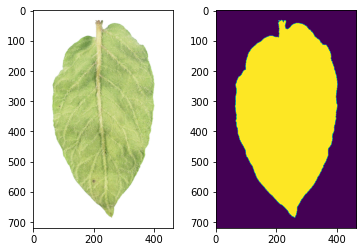

In [6]:
files_vis = ski.io.imread_collection("/home/theo/Bureau/DATA/Fluo_Visible_Mildiou_Maj2023/Train_dataset/Vis/*").files
files_gt = ski.io.imread_collection("/home/theo/Bureau/DATA/Fluo_Visible_Mildiou_Maj2023/Train_dataset/GT/*").files
vis = [ski.io.imread(image_path) for image_path in files_vis]
gt = [ski.io.imread(image_path) for image_path in files_gt]

vis_padded = [resize_padding(im, True, 720, 464) for im in vis]

gt_padded = [resize_padding(im, False, 720, 464) for im in gt]
for im in gt_padded:     
    im[im == 0] = 1
    im[im == 100] = 2
    im[im == 200] = 3

print('Example image:')
plt.subplot(121)
plt.imshow(vis_padded[25])
plt.subplot(122)
plt.imshow(gt_padded[25])
plt.show()

### First step: training Random Forest on a single image

Training image :


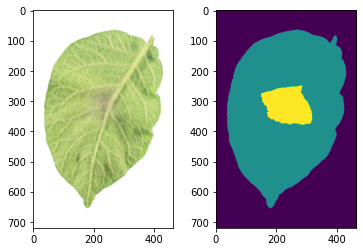

Text(0.5, 1.0, 'Image used for testing')

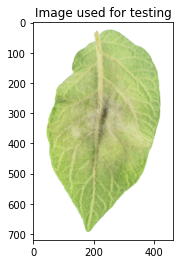

In [7]:
print('Training image :')
plt.subplot(1,2,1)
x_train = vis_padded[1]
plt.imshow(x_train)
plt.subplot(1,2,2)
y_train = gt_padded[1]
plt.imshow(y_train), plt.show()
x_test = vis_padded[5]
plt.imshow(x_test)
plt.title("Image used for testing")

The code used here for segmentation using Random Forest is heavily inspired by the example given on scikit-image website. More information here: <br>
https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_trainable_segmentation.html

In [ ]:
SIGMA_MIN = 1
SIGMA_MAX = 32

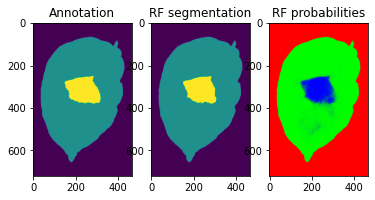

(<matplotlib.image.AxesImage at 0x7f7df886cee0>, None)

In [8]:
features_func = partial(feature.multiscale_basic_features,
                        intensity = True, edges = False, texture = True,
                        sigma_min = SIGMA_MIN, sigma_max = SIGMA_MAX,
                        channel_axis = -1)
features = features_func(x_train)
X = features.reshape(features.shape[0]*features.shape[1], features.shape[2])
clf = RandomForestClassifier(n_estimators = 100,
                             n_jobs = -1,
                             max_depth = 10,
                             max_samples = .05)
clf = future.fit_segmenter(y_train, features, clf)

result = future.predict_segmenter(features, clf)
result_prob = clf.predict_proba(X= X)
result_prob = result_prob.reshape(x_train.shape[0],x_train.shape[1], 3)

plt.subplot(131)
plt.gca().set_title("Annotation")
plt.imshow(y_train)
plt.subplot(132)
plt.gca().set_title("RF segmentation")
plt.imshow(result)
plt.subplot(133)
plt.gca().set_title("RF probabilities")
plt.imshow(result_prob), plt.show()

Use of the algorithm on the test image:

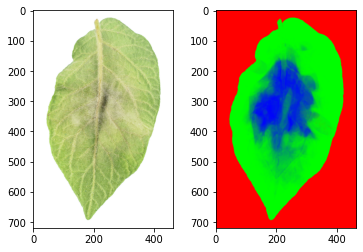

(<matplotlib.image.AxesImage at 0x7f7df9123520>, None)

In [9]:
features_new = features_func(x_test)
X = features_new.reshape(features_new.shape[0]*features_new.shape[1], features_new.shape[2])

pred_proba = clf.predict_proba(X = X)
pred_reshape = pred_proba.reshape(x_test.shape[0],x_test.shape[1], 3)

plt.subplot(1,2,1)
plt.imshow(x_test)
plt.subplot(1,2,2)
plt.imshow(pred_reshape), plt.show()

### Next step: training on the train dataset, testing on 1 image

**Features extraction**

In [10]:
n = len(vis_padded)
X = []
Y = []

for i in range(n):
    features = features_func(vis_padded[i])
    features = features.reshape(features.shape[0]*features.shape[1], features.shape[2])  

    keep_pixel = .2             # 20% of the total pixels are kept for training
    keep = random.sample(range(features.shape[0]), round(features.shape[0]*keep_pixel))
    features = np.array([features[i,:] for i in keep])
    label = gt_padded[i].ravel()
    label = np.array([label[i] for i in keep])

    X.append(features)
    Y.append(label)

X = np.array(X)
X = X.reshape(X.shape[0]*X.shape[1], X.shape[2])
Y = np.array(Y)
Y = Y.reshape(Y.shape[0]*Y.shape[1],)

**Randomized search for optimal hyperparameters**

In [ ]:
n_estimators = [50, 100, 150, 200]
max_depth = [4,6,8,10,12]
min_samples_split = [2, 5, 10, 20, 50]

random_grid = {'n_estimators': n_estimators,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'max_samples' : [.5]}

model_random = RandomizedSearchCV(estimator = RandomForestClassifier(), 
                                 param_distributions = random_grid,
                                 n_iter = 50,
                                 cv = 3)
model_random.fit(X, Y)
model_random.best_params_

Output from previous cell:

{'n_estimators': 150, <br>
 'min_samples_split': 5, <br>
 'max_samples': 0.5, <br>
 'max_depth': 12}

**Random forest classifier training**

In [12]:
print("X shape : {}\nY shape : {}".format(X.shape, Y.shape))
print("------------------------------------------------")
print("Training starts")
print("------------------------------------------------")

start = datetime.now()
clf = RandomForestClassifier(n_estimators=150, n_jobs= -1, min_samples_split=5,
                            max_depth=12, max_samples=.5,
                            verbose=0)

clf = future.fit_segmenter(Y, X, clf)
end = datetime.now()
comp_time = (end -start).seconds

print('Computation time for {} pixels : {} seconds'.format(X.shape[0], comp_time))

X shape : (4409856, 54)
Y shape : (4409856,)
------------------------------------------------
Training starts
------------------------------------------------
Computation time for 4409856 pixels : 290 seconds


**Show what features are the most important**

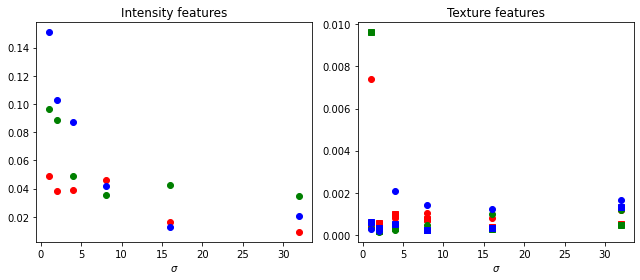

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
l = len(clf.feature_importances_)
feature_importance = (
        clf.feature_importances_[:l//3],
        clf.feature_importances_[l//3:2*l//3],
        clf.feature_importances_[2*l//3:])
sigmas = np.logspace(
        np.log2(SIGMA_MIN), np.log2(SIGMA_MAX),
        num=int(np.log2(SIGMA_MAX) - np.log2(SIGMA_MIN) + 1),
        base=2, endpoint=True)
for ch, color in zip(range(3), ['r', 'g', 'b']):
    ax[0].plot(sigmas, feature_importance[ch][::3], 'o', color=color)
    ax[0].set_title("Intensity features")
    ax[0].set_xlabel("$\\sigma$")
for ch, color in zip(range(3), ['r', 'g', 'b']):
    ax[1].plot(sigmas, feature_importance[ch][1::3], 'o', color=color)
    ax[1].plot(sigmas, feature_importance[ch][2::3], 's', color=color)
    ax[1].set_title("Texture features")
    ax[1].set_xlabel("$\\sigma$")

fig.tight_layout()

### Apply the model on a test image

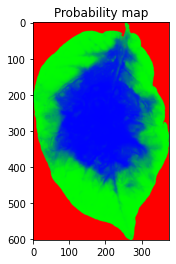

Jaccard score : 0.72012
Balanced accuracy : 0.84666


In [14]:
files_test_vis = ski.io.imread_collection("/home/theo/Bureau/DATA/Fluo_Visible_Mildiou_Maj2023/Test_dataset/Vis/*").files
files_test_gt = ski.io.imread_collection("/home/theo/Bureau/DATA/Fluo_Visible_Mildiou_Maj2023/Test_dataset/GT/*").files
test_vis = [ski.io.imread(image_path) for image_path in files_test_vis]
test_gt = [ski.io.imread(image_path) for image_path in files_test_gt]

for im in test_gt:       
    im[im == 0] = 0
    im[im == 100] = 1
    im[im == 200] = 2

num = 0                 # we try with the first image of the test dataset
img = test_vis[num]
true_label = test_gt[num]
or_shape = test_vis[num].shape

features_func = partial(feature.multiscale_basic_features,
                        intensity=True, edges=False, texture=True,
                        sigma_min=SIGMA_MIN, sigma_max=SIGMA_MAX,
                        channel_axis = -1)

features = features_func(img)
X = features.reshape(features.shape[0]*features.shape[1], features.shape[2])   

pred = future.predict_segmenter(X, clf)  # predicted class
pred_probas = clf.predict_proba(X)       # probabilities of each class

pred_reshape = pred.reshape(or_shape[0],or_shape[1])
pred_probas_reshape = pred_probas.reshape(or_shape[0],or_shape[1], 3)


#################################################################
# Display results
#################################################################

plt.imshow(pred_probas_reshape)
plt.title('Probability map')
plt.show()

pred_reshape[pred_reshape == 1] = 0
pred_reshape[pred_reshape == 2] = 1
pred_reshape[pred_reshape == 3] = 2

image_to_plot = np.concatenate((true_label*100, pred_reshape*100), axis = 1)  
cv2.imshow('result', image_to_plot)
cv2.waitKey(0)
cv2.destroyAllWindows()

#################################################################
# Metrics to evaluate the result
#################################################################
jac = jaccard_score(pd.DataFrame(pred), pd.DataFrame(true_label.flatten()), average='macro')   
b_accuracy = balanced_accuracy_score(pd.DataFrame(pred), pd.DataFrame(true_label.flatten()))
print("Jaccard score :", round(jac, 5))
print("Balanced accuracy :", round(b_accuracy, 5))

### Assess model performance on test dataset

In [14]:
features_func = partial(feature.multiscale_basic_features,
                        intensity=True, edges=False, texture=True,
                        sigma_min=SIGMA_MIN, sigma_max=SIGMA_MAX,
                        channel_axis = -1)

predictions = []
proba_map = []
proba_map_ch1 = []   #proba of background
proba_map_ch2 = []   #proba of healthy
proba_map_ch3 = []   #proba of infected
iou_score = []
b_accuracy_score = []

t = len(test_vis)

for i in range(t):
    img = test_vis[i]
    true_label = test_gt[i]
    or_shape = test_vis[i].shape
    features = features_func(img)
    X = features.reshape(features.shape[0]*features.shape[1], features.shape[2])

    pred = future.predict_segmenter(X, clf)
    pred_probas = clf.predict_proba(X)       
    
    pred_reshape = pred.reshape(or_shape[0], or_shape[1])
    pred_probas_reshape = pred_probas.reshape(or_shape[0],or_shape[1], 3)
    pred_reshape[pred_reshape == 1] = 0
    pred_reshape[pred_reshape == 2] = 1
    pred_reshape[pred_reshape == 3] = 2

    jac = jaccard_score(pd.DataFrame(pred), pd.DataFrame(true_label.flatten()), average='macro')  
    b_accuracy = balanced_accuracy_score(pd.DataFrame(pred), pd.DataFrame(true_label.flatten()))

    predictions.append(pred_reshape)
    proba_map.append(pred_probas_reshape)
    proba_map_ch1.append(pred_probas_reshape[:,:,0])
    proba_map_ch2.append(pred_probas_reshape[:,:,1])
    proba_map_ch3.append(pred_probas_reshape[:,:,2])
    iou_score.append(jac)
    b_accuracy_score.append(b_accuracy)
    
mean_IOU = np.mean(iou_score)
mean_b_acc = np.mean(b_accuracy_score)
print("############################################################")
print("Mean IoU obtained on test dataset : ", round(mean_IOU, 5))
print("Mean balanced accuracy obtained on test dataset : ", round(mean_b_acc, 5))
print("############################################################")

############################################################
Mean IoU obtained on test dataset :  0.83704
Mean balanced accuracy obtained on test dataset :  0.90254
############################################################


IoU : 0.72034
Balanced accuracy : 0.84676


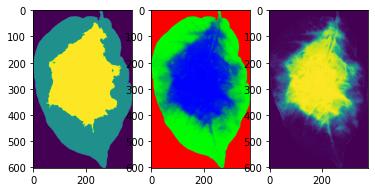

IoU : 0.78684
Balanced accuracy : 0.93607


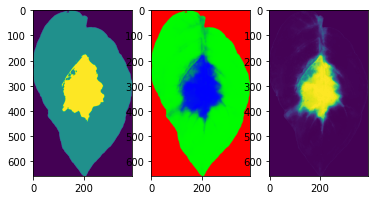

IoU : 0.99803
Balanced accuracy : 0.99919


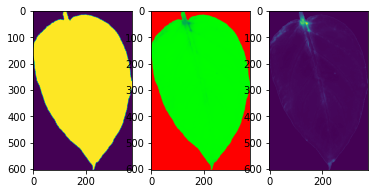

IoU : 0.6767
Balanced accuracy : 0.70147


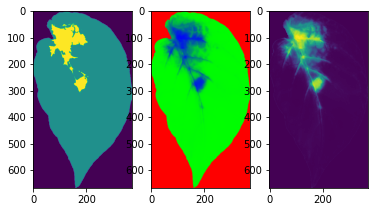

IoU : 0.91203
Balanced accuracy : 0.98907


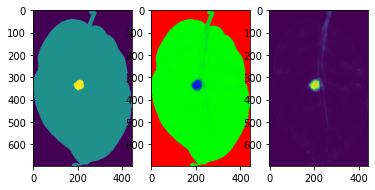

IoU : 0.92832
Balanced accuracy : 0.94271


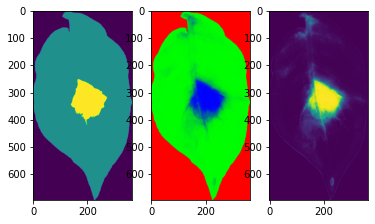

In [15]:
for i in range(t):
    print("IoU :", round(iou_score[i], 5))
    print("Balanced accuracy :", round(b_accuracy_score[i], 5))
    plt.subplot(131)
    plt.imshow(predictions[i])
    plt.subplot(132)
    plt.imshow(proba_map[i])
    plt.subplot(133)
    plt.imshow(proba_map_ch3[i])
    plt.show()

### Now we apply the model to all the images of the "visible" dataset

In [41]:
def segmentRF(img):
    """Segmentation of leaf image using Random Forest + probability map of infected

    Args:
        img (ndarray): image name
    Returns:
        pred_probas_reshape[:,:,2] (ndarray): probability map of infected
        pred_reshape*100 (ndarray): segmented image
    """
    or_shape = img.shape
    features_func = partial(feature.multiscale_basic_features,
                            intensity = True, edges = False, texture = True, 
                            sigma_min = SIGMA_MIN, sigma_max = SIGMA_MAX,
                            channel_axis = 1)

    features = features_func(img)
    X = features.reshape(features.shape[0]*features.shape[1], features.shape[2])

    pred = future.predict_segmenter(X, clf)  
    pred_probas = clf.predict_proba(X)
    
    pred_reshape = pred.reshape(or_shape[0],or_shape[1])
    pred_reshape[pred_reshape == 1] = 0
    pred_reshape[pred_reshape == 2] = 1
    pred_reshape[pred_reshape == 3] = 2

    pred_probas_reshape = pred_probas.reshape(or_shape[0],or_shape[1], 3)

    return pred_probas_reshape[:,:,2], pred_reshape*100

We will now apply the function to all visible images. We will also perform an additionnal postprocessing step, to ensure that a pixel at day t cannot have higher value than the one at day t+1.  

In [ ]:
folders = ski.io.imread_collection('/home/theo/Bureau/DATA/Fluo_Visible_Mildiou_Maj2023/Dossiers_Mildiou_Maj2023' + '/*')
iteration = 0
for folder in folders.files:
    iteration +=1
    if os.path.exists(folder + '/Segment_RF'):   
        shutil.rmtree(folder + '/Segment_RF')
    Images = ski.io.imread_collection(folder +  '/Recalibrated_CPD/*').files
    Visible = []
    for im in Images:
        if not any([x in im for x in ['Fv', 'Fo', 'Fm', 'FvFm', 'error']]):    
            Visible.append(im)
    Visible = sorted(Visible, key=str.casefold, reverse=True)   #sort in reverse order for upcoming postprocessing

    os.mkdir(folder + '/Segment_RF') 
    d = 0
    for im_path in Visible:
        im = ski.io.imread(im_path)
        res = segmentRF(im)

        if len(Visible) == 4 and "_J5_" not in im_path or len(Visible) == 3 and "_J4_" not in im_path: 
            p_map = res[0]
            seg = res[1]
            for i in range(p_map.shape[0]):
                for j in range(p_map.shape[1]):
                    if p_map[i, j] > p_map_upcoming_day[i, j]:
                        p_map[i, j] = p_map_upcoming_day[i, j]
            p_map_upcoming_day = p_map
        else:
            p_map = res[0]
            p_map_upcoming_day = p_map
            seg = res[1]

        ski.io.imsave(folder + '/Segment_RF' + '/P_map_'+ im_path.rsplit('/', 1)[-1], p_map)
        ski.io.imsave(folder + '/Segment_RF' + '/Seg_' + im_path.rsplit('/', 1)[-1], seg)

                  _________________________________
                 |.--------_--_------------_--__--.|
                 ||    /\ |_)|_)|   /\ | |(_ |_   ||
                 ;;`,_/``\|  |  |__/``\|_| _)|__ ,:|
                ((_(-,-----------.-.----------.-.)`)
                 \__ )        ,'     `.        \ _/
                 :  :        |_________|       :  :
                 |-'|       ,'-.-.--.-.`.      |`-|
                 |_.|      (( (*  )(*  )))     |._|
                 |  |       `.-`-'--`-'.'      |  |
                 |-'|        | ,-.-.-. |       |._|
                 |  |        |(|-|-|-|)|       |  |
                 :,':        |_`-'-'-'_|       ;`.;
                  \  \     ,'           `.    /._/
                   \/ `._ /_______________\_,'  /
                    \  / :   ___________   : \,'
                     `.| |  |           |  |,'
                       `.|  |           |  |
                         |  | SSt       |  |